In [6]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(context="notebook", palette="Spectral", style = 'darkgrid' ,font_scale = 1.5, color_codes=True)
import os
from scipy import stats
from sklearn.feature_selection import SelectKBest, chi2
import datetime
from datetime import timedelta
import math

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler 

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix, recall_score, precision_score

from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC

from imblearn.under_sampling import RandomUnderSampler

# Pré processamento

In [7]:
df = pd.read_csv("./weather.csv")
date = df['Date']    
df = df.drop(['Sunshine','Evaporation','Cloud3pm','Cloud9am','Location','RISK_MM'],axis=1) #remove id column
df = df.dropna()

sin = []
cos = []
for i, date in enumerate(df['Date']):
    d = date
    year, month, day = map(int, d.split('-'))
    d = datetime.date(year, month, day)
    day_number = d.timetuple().tm_yday
    sin.append(np.sin(math.pi*2*(day_number - 1)/364)) 
    cos.append(np.cos(math.pi*2*(day_number - 1)/364)) 
df['Date_cos'] = cos
df['Date_sin'] = sin    

wind_directions = {
    'N': 90.0, 
    'NNE': (90 + 45) / 2,
    'NE': 45.0,
    'ENE': (45) / 2,
    'E': 0.0,
    'ESE': (0 - 45) / 2,
    'SE': -45.0,
    'SSE': (-90 - 45) / 2,
    'S': -90.0,
    'SSW': (-90 - 135) / 2,
    'SW': -135.0,
    'WSW': (180 - 135) / 2,
    'W': 180.0,
    'WNW': (180 + 135) / 2,
    'NW': 135.0,
    'NNW': (135 + 90) / 2
}

df['RainTomorrow'].replace({'Yes': 1, 'No': 0}, inplace = True)
df['RainToday'].replace({'Yes': 1, 'No': 0}, inplace = True)

def log(x):
        return np.log(x+0.1)

df['Rainfall'] = df['Rainfall'].apply(log) 

for column in ['WindGustDir', 'WindDir9am', 'WindDir3pm']:
    df[column].replace(wind_directions, inplace = True)
    df[column + '_cos'] = df[column].apply(np.cos) 
    df[column + '_sin'] = df[column].apply(np.sin)
    df.drop([column], axis=1, inplace=True)
   

df_autocorr = df.copy()

df = df.drop(['Date'],axis=1) #remove unused date column
df.head()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,...,RainToday,RainTomorrow,Date_cos,Date_sin,WindGustDir_cos,WindGustDir_sin,WindDir9am_cos,WindDir9am_sin,WindDir3pm_cos,WindDir3pm_sin
0,13.4,22.9,-0.356675,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,...,0,0,0.877303,-0.479937,-0.598460,-0.801153,-0.598460,-0.801153,0.912939,0.408096
1,7.4,25.1,-2.302585,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,...,0,0,0.885456,-0.464723,0.912939,0.408096,0.826837,-0.562441,-0.873305,-0.487175
2,12.9,25.7,-2.302585,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,...,0,0,0.893346,-0.449370,-0.873305,-0.487175,-0.598460,-0.801153,-0.873305,-0.487175
3,9.2,28.0,-2.302585,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,...,0,0,0.900969,-0.433884,0.525322,0.850904,0.525322,-0.850904,1.000000,0.000000
4,17.5,32.3,0.095310,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,...,0,0,0.908324,-0.418268,-0.598460,-0.801153,-0.873305,-0.487175,-0.996088,0.088369


## Gráficos de autocorrelação

Os dois registros anteriores das vairáveis que apresentarem maior autocorrelação serão usados como variáveis de entrada do modelo

In [10]:
df_autocorr.index = pd.Index(df_autocorr['Date'].values.squeeze())
df_autocorr = df_autocorr.drop(['Date'], axis=1)

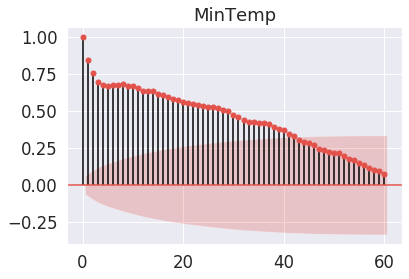

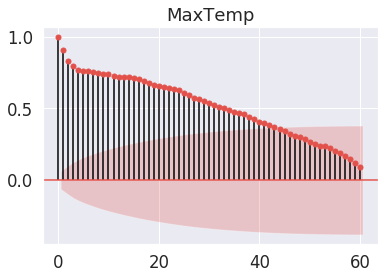

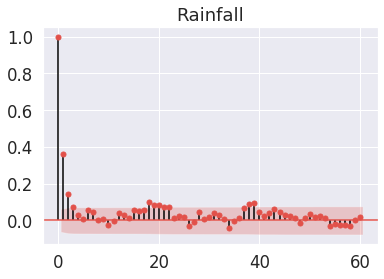

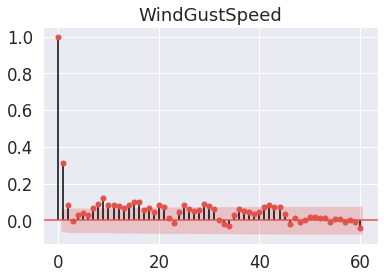

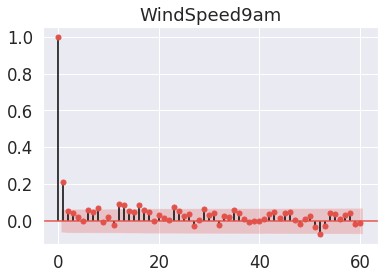

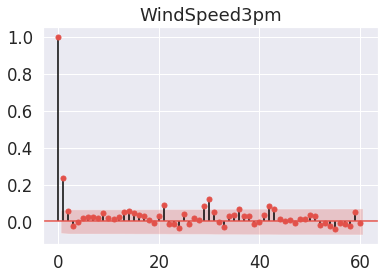

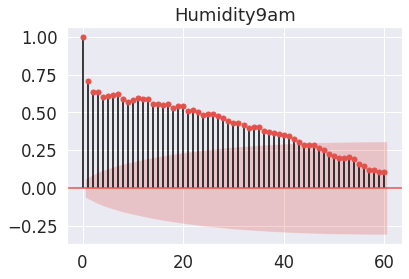

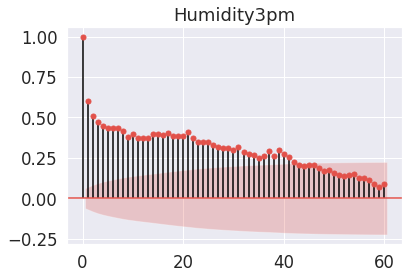

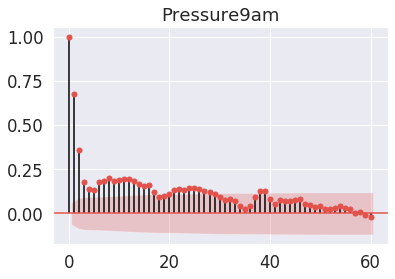

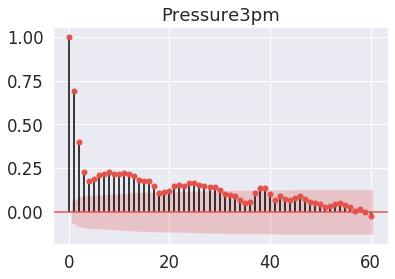

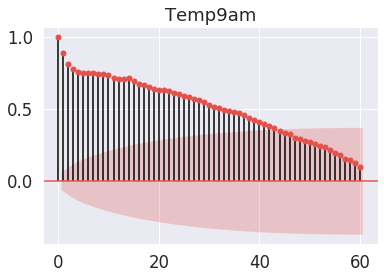

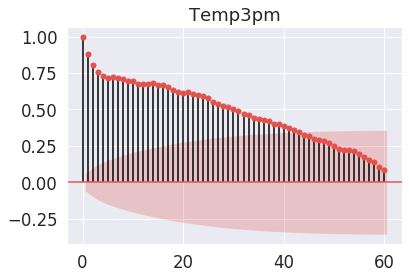

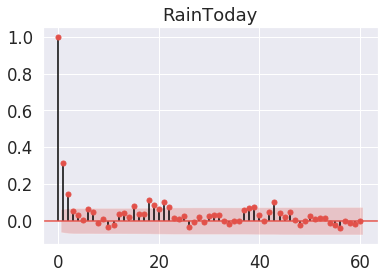

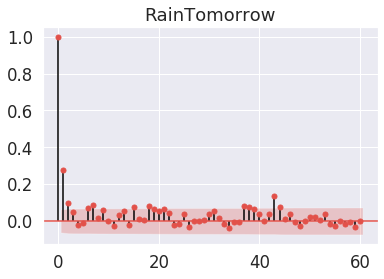

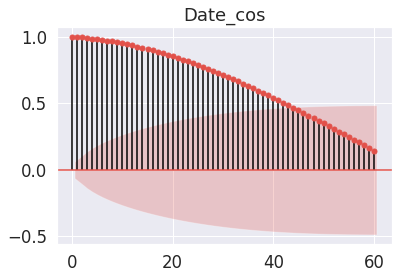

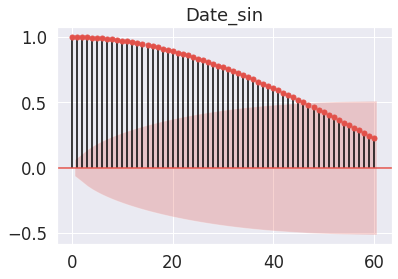

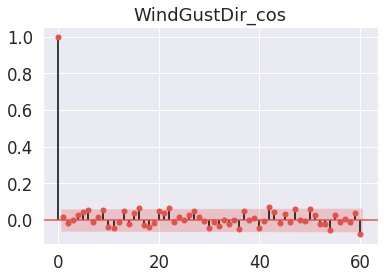

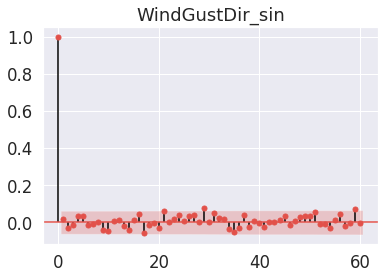

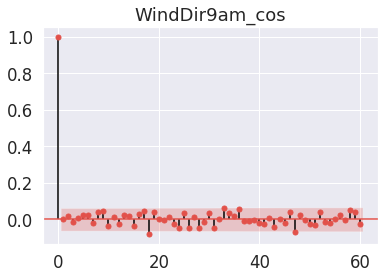

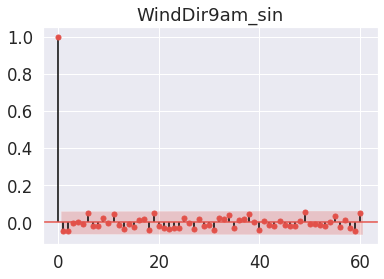

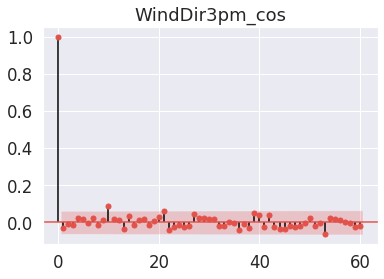

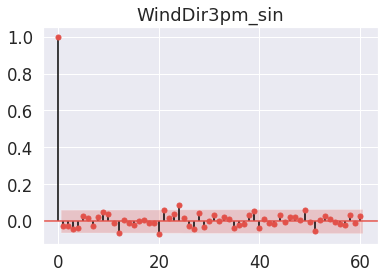

In [4]:
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm

for column in df_autocorr:
    sm.graphics.tsa.plot_acf(df_autocorr.drop(df_autocorr.columns.difference([column]), 1)[:1000].values.squeeze(), lags=60)
    plt.title(column)
    plt.show()

In [8]:
for col in df:
    if col in ["Humidity3pm","Humidity9am","MinTemp","MaxTemp"]:
        df[col+'-1'] = df[col].shift(periods=1, axis=0)
        df[col+'-2'] = df[col].shift(periods=2, axis=0)

df = df.iloc[2:]
df = df.reset_index(drop=True)
df.head()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,...,WindDir3pm_cos,WindDir3pm_sin,MinTemp-1,MinTemp-2,MaxTemp-1,MaxTemp-2,Humidity9am-1,Humidity9am-2,Humidity3pm-1,Humidity3pm-2
0,12.9,25.7,-2.302585,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,...,-0.873305,-0.487175,7.4,13.4,25.1,22.9,44.0,71.0,25.0,22.0
1,9.2,28.0,-2.302585,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,...,1.000000,0.000000,12.9,7.4,25.7,25.1,38.0,44.0,30.0,25.0
2,17.5,32.3,0.095310,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,...,-0.996088,0.088369,9.2,12.9,28.0,25.7,45.0,38.0,16.0,30.0
3,14.6,29.7,-1.203973,56.0,19.0,24.0,55.0,23.0,1009.2,1005.4,...,-0.598460,-0.801153,17.5,9.2,32.3,28.0,82.0,45.0,33.0,16.0
4,14.3,25.0,-2.302585,50.0,20.0,24.0,49.0,19.0,1009.6,1008.2,...,-0.598460,-0.801153,14.6,17.5,29.7,32.3,55.0,82.0,23.0,33.0


## Remoção de outliers

In [9]:
#Get mean distances

import time
from tqdm import tqdm
from sklearn.metrics import pairwise_distances_chunked

X = df.drop(['RainToday', 'RainTomorrow'],axis=1)
mean = []
chunks = pairwise_distances_chunked(X)
for chunk in tqdm(chunks):
    mean.extend(chunk.mean(1))

96it [03:23,  2.12s/it]


### Gráfico de distâncias ordenadas

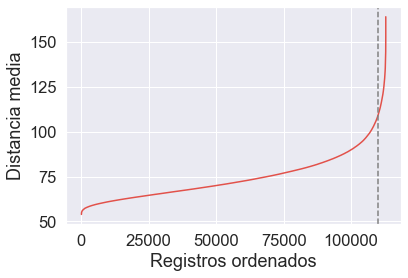

In [10]:
from ipywidgets import interact
import ipywidgets as widgets

sorted_mean = mean.copy()
sorted_mean.sort()

plt.plot(sorted_mean)
plt.xlabel('Registros ordenados')
plt.ylabel('Distancia media')
plt.axvline(x=110000, color="grey", linestyle="--")
plt.show()
    
    
# interact(plot, x=widgets.IntSlider(min=0, max=len(sorted_mean), step=1000, value=110000))

In [11]:
#Create dataframe without the outliers

df_distances = pd.DataFrame(mean, columns=["mean"])
df_distances = df_distances.sort_values(by=["mean"])
df_distances = df_distances.iloc[110000:]
df_distances.tail()

,mean
112029,151.242023
106475,151.770824
85848,153.097959
86533,161.331376
14762,164.165389


In [12]:
df = df.drop(df_distances.index.values.tolist())

## Análise de Componentes Principais
Removemos o número de componentes principais que nos permita manter 98% da variância total dos dados

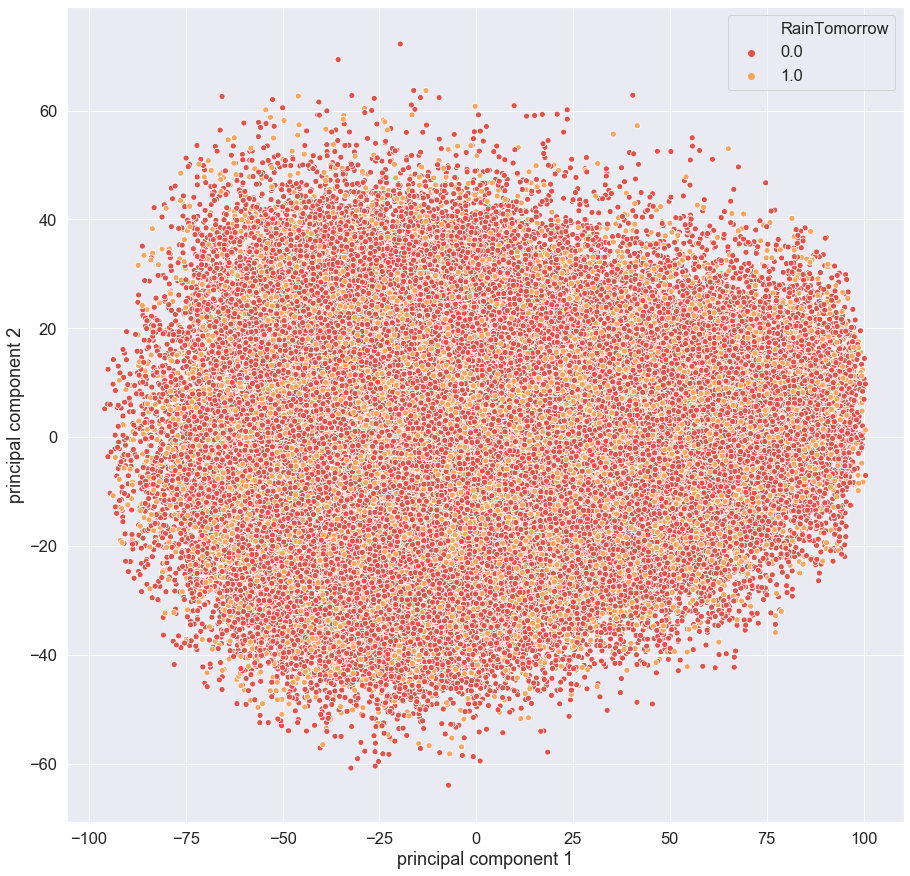

In [13]:
X = df.drop(['RainTomorrow', 'RainToday'], axis=1)

pca = PCA(n_components=2)
pca.fit(X)
principalComponents = pca.transform(X)
principalData = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

target = df['RainTomorrow'] 

fig, ax = plt.subplots(figsize=(15, 15))
sns.scatterplot(data=principalData, x='principal component 1', y='principal component 2',hue=target, ax=ax, legend='full')

<BarContainer object of 11 artists>

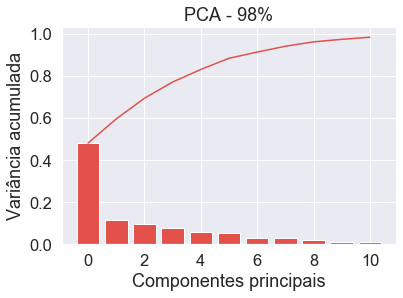

In [14]:
X = df.drop(['RainTomorrow', 'RainToday'], axis=1)

pca = PCA(n_components=0.98)
pca.fit(X)
X_pca = pca.transform(X)

#plot explained_variance
plt.title("PCA - 98%")
plt.ylabel('Variância acumulada')
plt.xlabel('Componentes principais')
plt.plot(np.cumsum(pca.explained_variance_ratio_))
y_pos = np.arange(len(pca.explained_variance_ratio_))
plt.bar(y_pos, pca.explained_variance_ratio_)

## Undersampling

In [38]:
# X = df.drop(['RainTomorrow', 'RainToday'], axis=1)
X = X_pca
y = df['RainTomorrow']

#Balancing classes with undersampling
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X, y)

# Split training data to enable model verification
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=26)

print("Shape")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print ("X_test:", X_test.shape)

Shape
X_train: (39529, 11)
y_train: (39529,)
X_test: (9883, 11)


# Modelos Lineares 

In [36]:
Cs = [0.001, 0.1, 1.0, 10.0]

models = [
#     {
#         'model': LogisticRegression(),
#         'name': 'LogisticRegression',
#         'parameters': [{
#             'penalty': ['l1','l2', 'elasticnet', 'none'],
#             'C': Cs,
#             'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
#         }]
#     },
    {
        'model': RandomForestClassifier(),
        'name': 'RandomForest',
        'parameters': [{
            'n_estimators': [10, 100, 200, 500, 1000, 2000, 3000],
            'max_depth': [None, 3, 5, 10, 20, 50],
            'max_features': ['auto', 'sqrt', 'log2']
        }]
    },
#     {
#         'model': DecisionTreeClassifier(),
#         'name': 'DecisionTree',
#         'parameters': [{
#             'max_depth': [1, 10, 20],
#             'min_samples_leaf': [3, 4, 5],
#             'min_samples_split': [8, 10, 12],
#         }]
#     },
#     {
#         'model': KNeighborsClassifier(),
#         'name': 'KNeighbors',
#         'parameters': [{
#             'n_neighbors': [1, 10, 20, 30],
#             'p': [1,2,3, 4, 5],
#         }]
#     }
]



In [37]:
for model in models:
    clf = GridSearchCV(model['model'], model['parameters'], cv=10, verbose=1, return_train_score=True, n_jobs=-1)
    clf.fit(X_train, y_train)

    results = pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score')
    results.to_csv('results_{0}_cv10_pca98_2.csv'.format(model['name']), index=False)

Fitting 10 folds for each of 126 candidates, totalling 1260 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   54.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 38.0min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 65.0min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 104.8min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed: 203.8min
[Parallel(n_jobs=-1)]: Done 1260 out of 1260 | elapsed: 221.1min finished


In [ ]:
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import recall_score
import warnings
warnings.filterwarnings('ignore')

models = [
#     LinearRegression(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()
]

names = [
#     'Linear Classifier',
    'Gaussian Naive Bayes',
    'Quadratic Discriminant Analysis',
]

for model, name in zip(models, names):
    scores = cross_validate(model, X_train, y_train, cv=10, scoring=['precision_macro','recall_macro','accuracy','f1_macro'])
    print("{}:\n\tPrecision: {}\n\tRecall: {}\n\tF1-Score: {}\n\tAccuracy: {}\n".format(name,np.mean(scores['test_precision_macro']),np.mean(scores['test_recall_macro']),np.mean(scores['test_f1_macro']), np.mean(scores['test_accuracy'])))
  
    y_pred = cross_val_predict(model, X_train, y_train, cv=10)
    confusion = confusion_matrix(y_resampled, y_pred)
    
    p = sns.heatmap(confusion, annot=True, fmt="d")
    plt.show()

# Modelos não lineares

## SVM

In [11]:
# gammas = ['auto', 'scale'] + [ 1.0, 10.0, 100.0, 1000.0]
gammas = [0.001,0.0001]
Cs = [1.0, 10.0]
# Cs = [1000.0]

parameters = [
    {
        'kernel': ['rbf'],
        'gamma': gammas,
        'C': Cs
    },
#     {
#         'kernel': ['linear'],
#         'C': Cs
#     },
#     {
#         'kernel': ['sigmoid'],
#         'gamma': [1, 0.5, 0.01],
#         'C': Cs
#     },
#     {
#         'kernel': ['poly'],
#         'gamma': ['scale'],
#         'degree': [2, 3, 4, 5],
#         'C': Cs
#     }
]

In [12]:
for param in parameters:
    print(param)
    clf = GridSearchCV(SVC(), param, cv=10, verbose=1, return_train_score=True, n_jobs=-1)
    clf.fit(X_resampled, y_resampled)

    results = pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score')
    results.to_csv('results_{0}_cv10_pca98_2.csv'.format(param['kernel'][0]), index=False)

{'gamma': [0.001, 0.0001], 'C': [1.0, 10.0], 'kernel': ['rbf']}
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 41.0min finished


In [16]:
clf = SVC(kernel='rbf', gamma='scale', C=1.0)
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [17]:
clf.score(X_test, y_test)

0.7794192046949306

### Melhor modelo: $\gamma = scale$ , $C = 1.0 $, $kernel: RBF$  

### Rede Neural

In [ ]:
from torch import nn, randn
import torch.nn.functional as F
from skorch import NeuralNetClassifier

class TorchModule(nn.Module):
    def __init__(self, num_units=10):
        super(TorchModule, self).__init__()

        self.activation = F.tanh
                
        self.hidden = nn.Linear(28, num_units)
        self.output = nn.Linear(num_units, 2)

    def forward(self, X, **kwargs):
        X = self.activation(self.hidden(X))
        X = F.softmax(self.output(X), dim=1)
        return X

net = NeuralNetClassifier(
    TorchModule,
    max_epochs=2,
    lr=0.1,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)

X = df.drop(['RainTomorrow', 'RainToday'], axis=1).values.astype(np.float32)
y = df['RainTomorrow'].values.astype(np.int64)

params = {
    'lr': [0.01, 0.02],
    'max_epochs': [10, 20],
    'module__num_units': [10, 20],
}
gs = GridSearchCV(net, params, refit=False, cv=3, scoring='accuracy')

gs.fit(X, y)
print(gs.best_score_, gs.best_params_)


In [40]:
X_train = tensor(X_train).float().to('cuda').cpu()
y_train = tensor(y_train).long().to('cuda').cpu()

In [47]:
type(y_train)

torch.Tensor

In [42]:
from torch import nn, randn, tanh, tensor
import torch.nn.functional as F
from skorch import NeuralNetClassifier

class TorchModule2(nn.Module):
    def __init__(self, num_units=10, activation=tanh):
        super(TorchModule2, self).__init__()

        self.activation = activation
        self.dropout = nn.Dropout(0.5)
        self.hidden1 = nn.Linear(11, num_units)
        self.output = nn.Linear(num_units, 2)

    def forward(self, X, **kwargs):
        X = self.activation(self.hidden1(X))
        X = self.dropout(X)
        X = F.softmax(self.output(X), dim=1)
        return X


# X_train = df.drop(['RainTomorrow', 'RainToday'], axis=1).values.astype(np.float32)
# y = df['RainTomorrow'].values.astype(np.int64)



In [56]:
net = NeuralNetClassifier(
    TorchModule2,
    max_epochs=2,
    lr=0.1,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    device='cuda'
)

# net.fit(X_train, y_train)

params = {
#    'lr': [0.01, 0.02],
    'lr': [0.01, 0.02],
    'max_epochs': [100],
    'module__num_units': [50, 75, 100],
    'module__activation': [tanh, F.relu, F.sigmoid]
}

gs = GridSearchCV(net, params, refit=False, cv=10, scoring='accuracy')

gs.fit(X_train.numpy(), y_train.numpy())
#print(gs.best_score_, gs.best_params_)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5813       0.7500        0.5169  1.0534
      2        0.5243       0.7598        0.5036  1.0353
      3        0.5146       0.7600        0.4971  1.1180
      4        0.5079       0.7629        0.4932  1.0542
      5        0.5044       0.7652        0.4901  1.0731
      6        0.5003       0.7656        0.4880  1.0737
      7        0.4980       0.7674        0.4860  1.0504
      8        0.4986       0.7688        0.4854  1.0685
      9        0.4952       0.7674        0.4835  1.1493
     10        0.4946       0.7678        0.4820  1.0480
     11        0.4910       0.7671        0.4808  1.0414
     12        0.4928       0.7693        0.4805  1.0647
     13        0.4898       0.7700        0.4796  1.0269
     14        0.4896       0.7725        0.4790  1.0227
     15        0.4899       0.7714        0.4786  1.0152
     16        0.4878       0.7

D:\Programs\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5963       0.7433        0.5301  1.2915
      2        0.5433       0.7539        0.5099  1.1888
      3        0.5274       0.7614        0.5015  1.1250
      4        0.5226       0.7610        0.4976  1.1649
      5        0.5202       0.7622        0.4948  1.0871
      6        0.5143       0.7619        0.4929  1.1579
      7        0.5142       0.7629        0.4912  1.1160
      8        0.5141       0.7631        0.4900  1.0921
      9        0.5083       0.7628        0.4881  1.0532
     10        0.5073       0.7652        0.4871  1.0961
     11        0.5076       0.7648        0.4864  1.0661
     12        0.5051       0.7646        0.4855  1.0931
     13        0.5039       0.7657        0.4850  1.1739
     14        0.5035       0.7657        0.4842  1.1729
     15        0.5024       0.7666        0.4838  1.1509
     16        0.5041       0.7

D:\Programs\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6140       0.7337        0.5564  1.0472
      2        0.5653       0.7463        0.5331  1.0532
      3        0.5474       0.7548        0.5202  1.0851
      4        0.5381       0.7577        0.5122  1.0502
      5        0.5300       0.7612        0.5072  1.0462
      6        0.5252       0.7614        0.5041  1.0593
      7        0.5221       0.7618        0.5013  1.0525
      8        0.5209       0.7619        0.4995  1.0532
      9        0.5164       0.7615        0.4979  1.0103
     10        0.5170       0.7619        0.4969  1.0492
     11        0.5113       0.7615        0.4956  1.0093
     12        0.5112       0.7625        0.4945  1.0532
     13        0.5094       0.7634        0.4932  1.0582
     14        0.5073       0.7621        0.4928  1.0731
     15        0.5062       0.7638        0.4918  1.0392
     16        0.5047       0.7

D:\Programs\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5977       0.7442        0.5401  1.0851
      2        0.5503       0.7492        0.5204  1.0951
      3        0.5395       0.7522        0.5133  1.0512
      4        0.5311       0.7574        0.5090  1.0851
      5        0.5272       0.7589        0.5060  1.0921
      6        0.5249       0.7610        0.5038  1.1380
      7        0.5226       0.7608        0.5017  1.0851
      8        0.5185       0.7624        0.4997  1.0941
      9        0.5170       0.7621        0.4983  1.0412
     10        0.5148       0.7632        0.4964  1.0402
     11        0.5128       0.7636        0.4950  1.0572
     12        0.5127       0.7648        0.4941  1.0751
     13        0.5095       0.7657        0.4928  1.0821
     14        0.5106       0.7662        0.4924  1.0721
     15        0.5066       0.7670        0.4916  1.0661
     16        0.5072       0.7

D:\Programs\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6023       0.7430        0.5355  1.0721
      2        0.5474       0.7541        0.5145  1.0821
      3        0.5342       0.7591        0.5056  1.0692
      4        0.5286       0.7632        0.5006  1.0542
      5        0.5216       0.7667        0.4973  1.0711
      6        0.5194       0.7678        0.4950  1.0632
      7        0.5167       0.7656        0.4928  1.0831
      8        0.5151       0.7678        0.4919  1.0263
      9        0.5103       0.7690        0.4914  1.0292
     10        0.5102       0.7688        0.4906  1.0342
     11        0.5068       0.7670        0.4894  1.1120
     12        0.5071       0.7685        0.4886  1.0472
     13        0.5076       0.7687        0.4887  1.0711
     14        0.5074       0.7685        0.4885  1.0402
     15        0.5069       0.7676        0.4884  1.0302
     16        0.5046       0.7

D:\Programs\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5806       0.7513        0.5237  1.0562
      2        0.5372       0.7591        0.5075  1.0821
      3        0.5282       0.7591        0.5021  1.0671
      4        0.5216       0.7607        0.4993  1.0881
      5        0.5184       0.7603        0.4982  1.1040
      6        0.5179       0.7604        0.4968  1.0402
      7        0.5170       0.7608        0.4965  1.0551
      8        0.5140       0.7635        0.4954  1.0432
      9        0.5122       0.7649        0.4945  1.0552
     10        0.5117       0.7653        0.4939  1.0362
     11        0.5117       0.7638        0.4933  1.0482
     12        0.5105       0.7657        0.4929  1.0721
     13        0.5083       0.7660        0.4925  1.0652
     14        0.5062       0.7657        0.4915  1.0552
     15        0.5068       0.7656        0.4913  1.0642
     16        0.5064       0.7

D:\Programs\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6026       0.7418        0.5379  1.0033
      2        0.5475       0.7544        0.5187  0.9780
      3        0.5373       0.7584        0.5101  0.9856
      4        0.5294       0.7610        0.5055  0.9874
      5        0.5213       0.7600        0.5013  0.9664
      6        0.5180       0.7608        0.4984  0.9774
      7        0.5181       0.7615        0.4969  0.9854
      8        0.5152       0.7670        0.4957  0.9744
      9        0.5133       0.7676        0.4937  0.9963
     10        0.5102       0.7649        0.4923  0.9773
     11        0.5084       0.7680        0.4921  0.9814
     12        0.5072       0.7674        0.4908  0.9794
     13        0.5074       0.7695        0.4903  1.0372
     14        0.5054       0.7690        0.4896  1.0153
     15        0.5023       0.7677        0.4890  0.9904
     16        0.5027       0.7

D:\Programs\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6174       0.7337        0.5468  0.9904
      2        0.5592       0.7537        0.5216  0.9904
      3        0.5413       0.7563        0.5109  0.9864
      4        0.5354       0.7582        0.5056  0.9844
      5        0.5319       0.7614        0.5027  1.0078
      6        0.5278       0.7624        0.5001  0.9874
      7        0.5220       0.7628        0.4979  0.9764
      8        0.5220       0.7643        0.4968  1.0004
      9        0.5183       0.7635        0.4954  0.9904
     10        0.5199       0.7648        0.4953  0.9968
     11        0.5162       0.7653        0.4949  1.1071
     12        0.5129       0.7638        0.4935  1.0033
     13        0.5130       0.7660        0.4938  0.9973
     14        0.5122       0.7660        0.4923  0.9933
     15        0.5138       0.7659        0.4920  1.0123
     16        0.5076       0.7

D:\Programs\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5969       0.7478        0.5343  1.0004
      2        0.5460       0.7569        0.5172  1.0013
      3        0.5351       0.7601        0.5097  0.9953
      4        0.5275       0.7582        0.5058  0.9913
      5        0.5217       0.7615        0.5024  0.9924
      6        0.5218       0.7631        0.5002  0.9844
      7        0.5206       0.7648        0.4990  1.0103
      8        0.5174       0.7639        0.4977  1.0831
      9        0.5129       0.7650        0.4962  0.9844
     10        0.5110       0.7652        0.4952  0.9834
     11        0.5123       0.7660        0.4945  0.9744
     12        0.5094       0.7667        0.4937  0.9793
     13        0.5095       0.7683        0.4933  0.9944
     14        0.5063       0.7694        0.4931  0.9963
     15        0.5093       0.7681        0.4923  0.9804
     16        0.5062       0.7

D:\Programs\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6079       0.7524        0.5292  1.0053
      2        0.5408       0.7573        0.5110  0.9824
      3        0.5307       0.7583        0.5051  0.9804
      4        0.5255       0.7603        0.5021  0.9844
      5        0.5198       0.7603        0.4998  0.9784
      6        0.5199       0.7615        0.4980  1.0981
      7        0.5180       0.7622        0.4966  0.9794
      8        0.5139       0.7652        0.4953  0.9724
      9        0.5121       0.7642        0.4943  0.9854
     10        0.5142       0.7670        0.4934  0.9784
     11        0.5115       0.7683        0.4941  0.9744
     12        0.5076       0.7660        0.4921  0.9834
     13        0.5079       0.7659        0.4914  0.9894
     14        0.5058       0.7673        0.4911  0.9704
     15        0.5071       0.7690        0.4914  0.9874
     16        0.5041       0.7

D:\Programs\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5944       0.7486        0.5313  0.9933
      2        0.5493       0.7579        0.5169  0.9994
      3        0.5385       0.7583        0.5110  1.0023
      4        0.5322       0.7586        0.5070  1.0607
      5        0.5276       0.7586        0.5045  1.0153
      6        0.5216       0.7619        0.5026  0.9844
      7        0.5250       0.7625        0.5018  0.9784
      8        0.5200       0.7612        0.4997  0.9884
      9        0.5194       0.7607        0.4988  0.9864
     10        0.5171       0.7622        0.4976  0.9774
     11        0.5164       0.7629        0.4971  0.9774
     12        0.5153       0.7621        0.4958  0.9944
     13        0.5123       0.7634        0.4942  0.9914
     14        0.5116       0.7631        0.4933  0.9964
     15        0.5097       0.7650        0.4928  0.9694
     16        0.5109       0.7

D:\Programs\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5782       0.7560        0.5145  0.9824
      2        0.5309       0.7622        0.4992  1.0552
      3        0.5203       0.7634        0.4935  1.0163
      4        0.5161       0.7648        0.4904  0.9734
      5        0.5107       0.7673        0.4885  1.0801
      6        0.5088       0.7669        0.4876  0.9834
      7        0.5061       0.7677        0.4861  0.9823
      8        0.5051       0.7666        0.4855  0.9744
      9        0.5022       0.7678        0.4846  0.9924
     10        0.5030       0.7681        0.4843  0.9854
     11        0.5023       0.7704        0.4845  1.0043
     12        0.4995       0.7685        0.4833  0.9724
     13        0.5007       0.7694        0.4827  0.9924
     14        0.4986       0.7688        0.4824  0.9973
     15        0.4998       0.7667        0.4821  0.9963
     16        0.4977       0.7

D:\Programs\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5911       0.7451        0.5281  0.9933
      2        0.5349       0.7541        0.5143  0.9913
      3        0.5227       0.7580        0.5094  0.9724
      4        0.5196       0.7607        0.5064  1.0023
      5        0.5163       0.7604        0.5040  0.9784
      6        0.5119       0.7600        0.5020  1.0023
      7        0.5109       0.7617        0.5006  0.9904
      8        0.5073       0.7607        0.4993  1.0013
      9        0.5101       0.7629        0.4984  0.9864
     10        0.5069       0.7619        0.4966  1.0054
     11        0.5014       0.7614        0.4960  0.9854
     12        0.5020       0.7605        0.4954  0.9994
     13        0.5030       0.7622        0.4942  0.9774
     14        0.5002       0.7615        0.4935  0.9912
     15        0.5012       0.7624        0.4927  1.0662
     16        0.4982       0.7

D:\Programs\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5829       0.7559        0.5164  0.9934
      2        0.5284       0.7607        0.5019  1.0023
      3        0.5188       0.7617        0.4975  0.9894
      4        0.5149       0.7612        0.4951  1.0013
      5        0.5089       0.7655        0.4936  0.9785
      6        0.5089       0.7611        0.4931  1.0053
      7        0.5062       0.7646        0.4920  0.9794
      8        0.5050       0.7648        0.4910  1.0113
      9        0.5033       0.7649        0.4904  0.9849
     10        0.5048       0.7663        0.4904  0.9963
     11        0.5020       0.7643        0.4901  0.9684
     12        0.5020       0.7666        0.4896  1.0661
     13        0.4994       0.7659        0.4886  1.0143
     14        0.5025       0.7653        0.4886  1.0123
     15        0.4992       0.7680        0.4886  0.9754
     16        0.4985       0.7

D:\Programs\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5792       0.7582        0.5209  0.9894
      2        0.5356       0.7624        0.5065  1.0103
      3        0.5248       0.7636        0.5006  0.9844
      4        0.5191       0.7660        0.4976  1.0143
      5        0.5158       0.7681        0.4960  1.0043
      6        0.5139       0.7683        0.4946  1.0013
      7        0.5090       0.7702        0.4938  0.9824
      8        0.5077       0.7676        0.4923  0.9964
      9        0.5070       0.7709        0.4918  0.9764
     10        0.5053       0.7681        0.4910  1.1131
     11        0.5057       0.7707        0.4903  0.9794
     12        0.5042       0.7721        0.4902  0.9974
     13        0.5027       0.7715        0.4903  0.9814
     14        0.5037       0.7680        0.4898  1.0013
     15        0.4997       0.7708        0.4889  0.9634
     16        0.4969       0.7

D:\Programs\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5894       0.7524        0.5211  0.9981
      2        0.5329       0.7635        0.5037  1.0053
      3        0.5202       0.7648        0.4974  0.9794
      4        0.5152       0.7663        0.4935  1.0143
      5        0.5134       0.7656        0.4914  0.9824
      6        0.5103       0.7635        0.4902  1.0134
      7        0.5073       0.7646        0.4895  1.0064
      8        0.5053       0.7657        0.4884  1.0572
      9        0.5040       0.7674        0.4881  0.9774
     10        0.5028       0.7667        0.4872  1.0402
     11        0.5037       0.7677        0.4870  0.9754
     12        0.5016       0.7683        0.4864  0.9954
     13        0.5011       0.7684        0.4869  0.9744
     14        0.5013       0.7677        0.4859  0.9930
     15        0.4997       0.7684        0.4857  0.9754
     16        0.4997       0.7

D:\Programs\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5980       0.7513        0.5207  0.9772
      2        0.5356       0.7646        0.5035  0.9792
      3        0.5248       0.7646        0.4970  0.9834
      4        0.5175       0.7653        0.4941  0.9784
      5        0.5127       0.7659        0.4922  1.0133
      6        0.5118       0.7680        0.4912  1.0442
      7        0.5093       0.7693        0.4909  0.9777
      8        0.5114       0.7688        0.4900  0.9714
      9        0.5080       0.7694        0.4893  0.9794
     10        0.5068       0.7697        0.4892  0.9754
     11        0.5091       0.7674        0.4886  0.9854
     12        0.5056       0.7726        0.4879  0.9814
     13        0.5054       0.7711        0.4873  0.9824
     14        0.5028       0.7715        0.4870  0.9724
     15        0.5021       0.7701        0.4863  0.9786
     16        0.5028       0.7

D:\Programs\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5948       0.7482        0.5290  0.9774
      2        0.5437       0.7607        0.5094  0.9943
      3        0.5306       0.7628        0.5023  0.9714
      4        0.5235       0.7650        0.4975  1.0402
      5        0.5215       0.7632        0.4953  1.0223
      6        0.5171       0.7631        0.4925  0.9764
      7        0.5134       0.7652        0.4909  0.9794
      8        0.5128       0.7667        0.4904  0.9720
      9        0.5085       0.7657        0.4894  0.9814
     10        0.5095       0.7677        0.4894  0.9874
     11        0.5071       0.7676        0.4885  0.9745
     12        0.5038       0.7656        0.4879  0.9734
     13        0.5006       0.7666        0.4869  0.9830
     14        0.5027       0.7680        0.4870  0.9694
     15        0.5025       0.7691        0.4864  0.9714
     16        0.4991       0.7

D:\Programs\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5881       0.7552        0.5202  0.9784
      2        0.5327       0.7646        0.5052  0.9854
      3        0.5227       0.7677        0.5008  1.0741
      4        0.5164       0.7666        0.4980  0.9804
      5        0.5147       0.7678        0.4962  0.9784
      6        0.5160       0.7676        0.4952  0.9933
      7        0.5137       0.7680        0.4941  0.9824
      8        0.5105       0.7691        0.4934  0.9734
      9        0.5037       0.7684        0.4923  0.9804
     10        0.5044       0.7690        0.4912  0.9993
     11        0.5073       0.7690        0.4908  0.9844
     12        0.5054       0.7681        0.4908  0.9864
     13        0.5024       0.7705        0.4904  0.9953
     14        0.5027       0.7695        0.4893  0.9744
     15        0.5010       0.7690        0.4892  0.9804
     16        0.5031       0.7

D:\Programs\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5761       0.7522        0.5236  1.0432
      2        0.5335       0.7576        0.5087  1.0123
      3        0.5244       0.7625        0.5034  0.9884
      4        0.5178       0.7631        0.5002  0.9844
      5        0.5143       0.7664        0.4986  0.9831
      6        0.5129       0.7656        0.4971  0.9920
      7        0.5086       0.7676        0.4957  0.9783
      8        0.5054       0.7673        0.4948  0.9714
      9        0.5094       0.7684        0.4950  0.9701
     10        0.5036       0.7673        0.4936  0.9816
     11        0.5045       0.7684        0.4931  0.9694
     12        0.5034       0.7680        0.4932  0.9814
     13        0.5036       0.7693        0.4920  0.9874
     14        0.5013       0.7678        0.4921  0.9904
     15        0.5005       0.7685        0.4912  0.9704
     16        0.4985       0.7

D:\Programs\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5808       0.7421        0.5262  0.9714
      2        0.5360       0.7563        0.5094  0.9824
      3        0.5264       0.7590        0.5027  0.9826
      4        0.5192       0.7631        0.4987  0.9867
      5        0.5174       0.7634        0.4968  0.9824
      6        0.5143       0.7629        0.4951  0.9794
      7        0.5095       0.7634        0.4933  0.9854
      8        0.5076       0.7642        0.4919  0.9834
      9        0.5089       0.7652        0.4917  0.9894
     10        0.5057       0.7626        0.4905  0.9958
     11        0.5056       0.7655        0.4898  0.9791
     12        0.5041       0.7635        0.4891  0.9834
     13        0.5034       0.7664        0.4894  0.9754
     14        0.5029       0.7660        0.4890  0.9754
     15        0.5021       0.7652        0.4884  1.0921
     16        0.5007       0.7

D:\Programs\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5886       0.7624        0.5054  0.9784
      2        0.5231       0.7669        0.4923  0.9854
      3        0.5171       0.7702        0.4887  0.9774
      4        0.5113       0.7670        0.4871  0.9794
      5        0.5075       0.7683        0.4852  0.9769
      6        0.5038       0.7690        0.4845  0.9865
      7        0.5023       0.7688        0.4838  0.9864
      8        0.5011       0.7662        0.4828  0.9842
      9        0.5009       0.7670        0.4826  0.9844
     10        0.4961       0.7670        0.4816  0.9804
     11        0.4999       0.7666        0.4815  0.9764
     12        0.4985       0.7670        0.4811  0.9884
     13        0.4968       0.7678        0.4807  1.0323
     14        0.4974       0.7674        0.4803  1.0213
     15        0.4969       0.7673        0.4802  0.9744
     16        0.4966       0.7

D:\Programs\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5703       0.7431        0.5208  0.9834
      2        0.5313       0.7544        0.5062  0.9993
      3        0.5193       0.7551        0.5009  0.9814
      4        0.5139       0.7572        0.4977  0.9864
      5        0.5086       0.7608        0.4957  0.9913
      6        0.5064       0.7603        0.4941  0.9854
      7        0.5061       0.7629        0.4933  0.9913
      8        0.5017       0.7614        0.4916  0.9854
      9        0.5018       0.7625        0.4913  0.9854
     10        0.5016       0.7650        0.4907  0.9977
     11        0.5005       0.7638        0.4898  0.9894
     12        0.4984       0.7648        0.4901  1.1041
     13        0.4985       0.7641        0.4903  0.9884
     14        0.4974       0.7646        0.4893  0.9923
     15        0.4951       0.7663        0.4889  0.9852
     16        0.4964       0.7

D:\Programs\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5695       0.7612        0.5131  0.9784
      2        0.5271       0.7631        0.5006  0.9844
      3        0.5180       0.7645        0.4967  1.0033
      4        0.5158       0.7628        0.4953  1.0083
      5        0.5118       0.7649        0.4938  1.0093
      6        0.5093       0.7643        0.4929  1.0163
      7        0.5066       0.7650        0.4920  1.0073
      8        0.5056       0.7649        0.4914  1.0213
      9        0.5079       0.7673        0.4908  1.0911
     10        0.5044       0.7653        0.4903  1.0342
     11        0.5037       0.7656        0.4904  0.9994
     12        0.5036       0.7662        0.4899  1.0193
     13        0.5040       0.7690        0.4904  1.0143
     14        0.5015       0.7671        0.4889  1.0043
     15        0.5017       0.7671        0.4887  1.0203
     16        0.4997       0.7

D:\Programs\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5796       0.7541        0.5196  0.9794
      2        0.5322       0.7579        0.5063  0.9983
      3        0.5227       0.7642        0.4996  0.9724
      4        0.5177       0.7685        0.4972  1.0048
      5        0.5140       0.7698        0.4950  0.9904
      6        0.5085       0.7707        0.4929  0.9824
      7        0.5074       0.7722        0.4917  1.0701
      8        0.5058       0.7683        0.4909  1.0153
      9        0.5045       0.7700        0.4901  0.9774
     10        0.5013       0.7722        0.4894  0.9933
     11        0.5023       0.7723        0.4890  0.9874
     12        0.5007       0.7715        0.4886  0.9844
     13        0.4974       0.7723        0.4873  0.9884
     14        0.4999       0.7704        0.4876  0.9964
     15        0.4978       0.7716        0.4875  0.9674
     16        0.4985       0.7

D:\Programs\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5780       0.7473        0.5203  0.9744
      2        0.5365       0.7569        0.5074  0.9784
      3        0.5234       0.7600        0.5008  0.9804
      4        0.5174       0.7622        0.4979  0.9784
      5        0.5148       0.7629        0.4956  1.0462
      6        0.5132       0.7653        0.4944  1.0263
      7        0.5083       0.7655        0.4926  0.9784
      8        0.5092       0.7662        0.4915  1.0060
      9        0.5071       0.7688        0.4911  0.9784
     10        0.5054       0.7691        0.4904  0.9724
     11        0.5058       0.7687        0.4896  0.9973
     12        0.5032       0.7695        0.4899  0.9744
     13        0.5036       0.7697        0.4881  0.9714
     14        0.4992       0.7722        0.4879  0.9824
     15        0.4990       0.7715        0.4870  0.9734
     16        0.4983       0.7

D:\Programs\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5944       0.7530        0.5252  0.9845
      2        0.5356       0.7587        0.5093  0.9913
      3        0.5257       0.7598        0.5025  0.9814
      4        0.5183       0.7622        0.4991  1.1021
      5        0.5158       0.7638        0.4968  1.0063
      6        0.5135       0.7655        0.4954  0.9864
      7        0.5121       0.7635        0.4942  0.9844
      8        0.5091       0.7626        0.4931  0.9923
      9        0.5089       0.7643        0.4925  0.9943
     10        0.5062       0.7643        0.4916  0.9884
     11        0.5083       0.7674        0.4913  0.9764
     12        0.5049       0.7676        0.4905  0.9954
     13        0.5034       0.7659        0.4896  0.9934
     14        0.5023       0.7670        0.4900  1.0063
     15        0.5010       0.7624        0.4897  0.9890
     16        0.5004       0.7

D:\Programs\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5790       0.7562        0.5156  1.0353
      2        0.5273       0.7604        0.5030  1.0452
      3        0.5189       0.7643        0.4978  0.9894
      4        0.5137       0.7662        0.4957  0.9733
      5        0.5091       0.7674        0.4939  0.9794
      6        0.5057       0.7666        0.4938  0.9834
      7        0.5048       0.7687        0.4909  0.9804
      8        0.5039       0.7680        0.4905  0.9704
      9        0.5016       0.7688        0.4896  0.9724
     10        0.5007       0.7684        0.4894  0.9904
     11        0.5019       0.7701        0.4885  0.9854
     12        0.4984       0.7693        0.4879  0.9774
     13        0.4974       0.7680        0.4872  0.9794
     14        0.4970       0.7694        0.4872  0.9854
     15        0.4951       0.7691        0.4862  0.9854
     16        0.4941       0.7

D:\Programs\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5864       0.7500        0.5234  0.9774
      2        0.5319       0.7570        0.5095  0.9934
      3        0.5223       0.7612        0.5042  0.9894
      4        0.5160       0.7643        0.5001  0.9794
      5        0.5137       0.7656        0.4981  0.9805
      6        0.5107       0.7677        0.4963  0.9864
      7        0.5091       0.7674        0.4948  0.9874
      8        0.5051       0.7669        0.4935  0.9854
      9        0.5056       0.7684        0.4928  0.9904
     10        0.5025       0.7677        0.4917  0.9953
     11        0.5023       0.7709        0.4916  0.9844
     12        0.5033       0.7685        0.4911  0.9824
     13        0.4996       0.7701        0.4903  0.9844
     14        0.4997       0.7700        0.4902  0.9834
     15        0.4993       0.7676        0.4895  1.1030
     16        0.4999       0.7

D:\Programs\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5744       0.7621        0.5116  0.9664
      2        0.5236       0.7634        0.5002  0.9694
      3        0.5167       0.7667        0.4958  0.9774
      4        0.5104       0.7670        0.4933  0.9953
      5        0.5093       0.7688        0.4921  0.9774
      6        0.5063       0.7687        0.4906  0.9744
      7        0.5049       0.7711        0.4901  0.9874
      8        0.5052       0.7698        0.4890  0.9734
      9        0.5019       0.7702        0.4879  1.0273
     10        0.4987       0.7709        0.4886  0.9943
     11        0.4971       0.7728        0.4876  0.9806
     12        0.4980       0.7705        0.4863  0.9794
     13        0.4992       0.7677        0.4865  1.0921
     14        0.4952       0.7715        0.4862  0.9874
     15        0.4953       0.7667        0.4865  0.9754
     16        0.4958       0.7

D:\Programs\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5786       0.7517        0.5192  0.9874
      2        0.5321       0.7598        0.5065  0.9789
      3        0.5235       0.7584        0.5023  0.9954
      4        0.5166       0.7660        0.4976  0.9864
      5        0.5170       0.7643        0.4970  0.9874
      6        0.5108       0.7652        0.4945  0.9954
      7        0.5081       0.7653        0.4931  1.0033
      8        0.5096       0.7673        0.4927  0.9972
      9        0.5047       0.7670        0.4916  0.9944
     10        0.5045       0.7660        0.4919  0.9954
     11        0.5050       0.7671        0.4906  1.0373
     12        0.5033       0.7691        0.4907  1.0462
     13        0.5011       0.7684        0.4895  0.9981
     14        0.5002       0.7715        0.4895  0.9951
     15        0.4998       0.7695        0.4880  0.9974
     16        0.4963       0.7

D:\Programs\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5783       0.7589        0.5146  1.0333
      2        0.5294       0.7624        0.4986  1.0442
      3        0.5194       0.7618        0.4936  1.0282
      4        0.5178       0.7664        0.4907  1.0213
      5        0.5133       0.7673        0.4886  1.0382
      6        0.5086       0.7680        0.4863  1.0292
      7        0.5059       0.7666        0.4850  1.0312
      8        0.5050       0.7678        0.4844  1.0492
      9        0.5034       0.7669        0.4834  1.1230
     10        0.5006       0.7663        0.4822  1.0512
     11        0.4982       0.7691        0.4818  1.0372
     12        0.4977       0.7684        0.4812  1.0333
     13        0.4975       0.7678        0.4816  1.0263
     14        0.4963       0.7694        0.4810  1.0173
     15        0.4974       0.7701        0.4827  1.0223
     16        0.4953       0.7

D:\Programs\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5775       0.7510        0.5208  1.0293
      2        0.5328       0.7553        0.5082  1.0263
      3        0.5261       0.7587        0.5032  1.1509
      4        0.5190       0.7628        0.5007  1.0562
      5        0.5157       0.7642        0.4984  1.0183
      6        0.5140       0.7648        0.4969  1.0253
      7        0.5119       0.7674        0.4957  1.0263
      8        0.5085       0.7645        0.4936  1.0362
      9        0.5054       0.7659        0.4931  1.0761
     10        0.5055       0.7680        0.4921  1.0432
     11        0.5018       0.7669        0.4911  1.0233
     12        0.5029       0.7676        0.4913  1.0522
     13        0.5013       0.7681        0.4908  1.0492
     14        0.5021       0.7684        0.4899  1.0422
     15        0.4992       0.7678        0.4901  1.0522
     16        0.5023       0.7

D:\Programs\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5682       0.7614        0.5075  1.0263
      2        0.5222       0.7678        0.4945  1.0402
      3        0.5155       0.7685        0.4911  1.0283
      4        0.5118       0.7694        0.4902  1.0432
      5        0.5085       0.7691        0.4888  1.0353
      6        0.5078       0.7716        0.4880  1.0153
      7        0.5055       0.7705        0.4881  1.0323
      8        0.5039       0.7700        0.4874  1.0213
      9        0.5033       0.7704        0.4879  1.0781
     10        0.5038       0.7705        0.4873  1.1489
     11        0.5008       0.7709        0.4856  1.0332
     12        0.5011       0.7708        0.4868  1.0273
     13        0.5001       0.7711        0.4862  1.0312
     14        0.5008       0.7705        0.4850  1.0292
     15        0.4970       0.7680        0.4855  1.0183
     16        0.4984       0.7

D:\Programs\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5650       0.7635        0.5078  1.0741
      2        0.5265       0.7670        0.4986  1.0352
      3        0.5154       0.7687        0.4941  1.1290
      4        0.5153       0.7698        0.4916  1.0492
      5        0.5083       0.7684        0.4895  1.0292
      6        0.5044       0.7694        0.4888  1.0163
      7        0.5026       0.7694        0.4878  1.0312
      8        0.5035       0.7712        0.4885  1.0243
      9        0.5019       0.7667        0.4872  1.0263
     10        0.5002       0.7712        0.4867  1.0851
     11        0.5002       0.7711        0.4864  1.0203
     12        0.4988       0.7690        0.4866  1.0402
     13        0.4979       0.7688        0.4864  1.0194
     14        0.4981       0.7733        0.4871  1.0193
     15        0.4981       0.7707        0.4866  1.0352
     16        0.4954       0.7

D:\Programs\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5839       0.7480        0.5234  1.0373
      2        0.5384       0.7545        0.5100  1.0342
      3        0.5279       0.7587        0.5050  1.0323
      4        0.5259       0.7593        0.5006  1.0283
      5        0.5176       0.7615        0.4985  1.0263
      6        0.5157       0.7628        0.4969  1.0372
      7        0.5149       0.7626        0.4954  1.0402
      8        0.5088       0.7631        0.4942  1.0512
      9        0.5087       0.7625        0.4930  1.0512
     10        0.5070       0.7649        0.4928  1.1479
     11        0.5047       0.7653        0.4912  1.0392
     12        0.5039       0.7663        0.4911  1.0233
     13        0.5031       0.7645        0.4901  1.0392
     14        0.5030       0.7662        0.4889  1.0193
     15        0.5039       0.7678        0.4887  1.0253
     16        0.5015       0.7

D:\Programs\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5805       0.7517        0.5170  1.0721
      2        0.5314       0.7641        0.5019  1.0811
      3        0.5199       0.7680        0.4963  1.1489
      4        0.5151       0.7681        0.4949  1.0292
      5        0.5103       0.7680        0.4923  1.0233
      6        0.5122       0.7697        0.4923  1.0293
      7        0.5097       0.7681        0.4904  1.0263
      8        0.5073       0.7711        0.4896  1.0462
      9        0.5068       0.7683        0.4888  1.0273
     10        0.5049       0.7681        0.4892  1.0592
     11        0.5031       0.7697        0.4883  1.0522
     12        0.5012       0.7693        0.4878  1.0412
     13        0.4999       0.7716        0.4874  1.0322
     14        0.5002       0.7718        0.4873  1.0373
     15        0.5007       0.7700        0.4869  1.0243
     16        0.4984       0.7

D:\Programs\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5640       0.7611        0.5103  1.0542
      2        0.5280       0.7629        0.4992  1.0392
      3        0.5187       0.7664        0.4956  1.0552
      4        0.5149       0.7673        0.4936  1.0402
      5        0.5110       0.7684        0.4922  1.0412
      6        0.5065       0.7690        0.4903  1.0462
      7        0.5073       0.7690        0.4897  1.0373
      8        0.5053       0.7676        0.4884  1.0382
      9        0.5039       0.7711        0.4886  1.0432
     10        0.5017       0.7660        0.4878  1.1778
     11        0.5013       0.7671        0.4876  1.0392
     12        0.4985       0.7676        0.4873  1.0372
     13        0.4972       0.7697        0.4870  1.0402
     14        0.4988       0.7664        0.4878  1.0412
     15        0.4968       0.7688        0.4867  1.0402
     16        0.4964       0.7

D:\Programs\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5999       0.7579        0.5239  1.0632
      2        0.5379       0.7618        0.5034  1.0831
      3        0.5264       0.7618        0.4991  1.1429
      4        0.5174       0.7645        0.4971  1.0422
      5        0.5155       0.7660        0.4946  1.0273
      6        0.5110       0.7662        0.4933  1.0562
      7        0.5094       0.7655        0.4927  1.0422
      8        0.5073       0.7662        0.4917  1.0292
      9        0.5061       0.7685        0.4911  1.0333
     10        0.5015       0.7680        0.4893  1.0771
     11        0.5031       0.7670        0.4881  1.0392
     12        0.5038       0.7652        0.4886  1.0422
     13        0.5032       0.7657        0.4891  1.0373
     14        0.5019       0.7694        0.4877  1.0203
     15        0.5015       0.7685        0.4879  1.0243
     16        0.4999       0.7

D:\Programs\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5728       0.7619        0.5125  0.9754
      2        0.5309       0.7621        0.5012  0.9784
      3        0.5218       0.7625        0.4956  1.0288
      4        0.5143       0.7655        0.4927  0.9953
      5        0.5134       0.7687        0.4927  0.9858
      6        0.5088       0.7674        0.4899  0.9894
      7        0.5065       0.7714        0.4908  0.9854
      8        0.5065       0.7671        0.4889  0.9844
      9        0.5014       0.7670        0.4870  0.9744
     10        0.5008       0.7695        0.4868  1.0203
     11        0.5016       0.7695        0.4868  1.0442
     12        0.4995       0.7693        0.4860  1.0113
     13        0.4993       0.7656        0.4865  0.9964
     14        0.4986       0.7671        0.4854  0.9814
     15        0.4987       0.7687        0.4857  0.9794
     16        0.4969       0.7

D:\Programs\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5753       0.7556        0.5180  0.9914
      2        0.5403       0.7614        0.5077  0.9813
      3        0.5283       0.7615        0.5024  0.9924
      4        0.5231       0.7666        0.4980  0.9777
      5        0.5165       0.7629        0.4946  0.9854
      6        0.5127       0.7673        0.4942  0.9909
      7        0.5126       0.7631        0.4929  0.9774
      8        0.5088       0.7676        0.4919  1.0153
      9        0.5063       0.7656        0.4898  1.0741
     10        0.5062       0.7659        0.4895  0.9844
     11        0.5023       0.7680        0.4890  0.9729
     12        0.5034       0.7687        0.4889  0.9814
     13        0.5018       0.7656        0.4883  1.0083
     14        0.5017       0.7684        0.4877  0.9914
     15        0.5026       0.7667        0.4883  0.9894
     16        0.5007       0.7

D:\Programs\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5688       0.7636        0.4995  0.9864
      2        0.5185       0.7664        0.4898  0.9904
      3        0.5133       0.7712        0.4896  0.9784
      4        0.5131       0.7685        0.4858  0.9774
      5        0.5059       0.7705        0.4848  0.9894
      6        0.5032       0.7685        0.4845  1.0612
      7        0.5023       0.7685        0.4840  1.0003
      8        0.5003       0.7676        0.4828  0.9877
      9        0.5023       0.7698        0.4836  0.9924
     10        0.5014       0.7732        0.4867  0.9784
     11        0.4981       0.7681        0.4821  0.9911
     12        0.4957       0.7685        0.4820  0.9734
     13        0.4975       0.7688        0.4811  0.9794
     14        0.4951       0.7685        0.4806  0.9814
     15        0.4974       0.7683        0.4815  1.0073
     16        0.4958       0.7

D:\Programs\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5596       0.7598        0.5094  1.0075
      2        0.5222       0.7610        0.5011  0.9944
      3        0.5186       0.7629        0.4980  1.0143
      4        0.5123       0.7631        0.4953  1.0382
      5        0.5085       0.7653        0.4935  0.9904
      6        0.5061       0.7681        0.4918  0.9944
      7        0.5001       0.7680        0.4904  1.0038
      8        0.5001       0.7656        0.4897  0.9774
      9        0.5002       0.7664        0.4883  0.9804
     10        0.4987       0.7648        0.4893  1.0133
     11        0.4951       0.7673        0.4884  0.9864
     12        0.4952       0.7684        0.4893  0.9874
     13        0.4958       0.7656        0.4872  0.9904
     14        0.4966       0.7660        0.4865  0.9894
     15        0.4926       0.7678        0.4882  0.9674
     16        0.4936       0.7

D:\Programs\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5682       0.7591        0.5085  1.0023
      2        0.5228       0.7657        0.4966  1.0502
      3        0.5154       0.7664        0.4927  0.9743
      4        0.5128       0.7684        0.4915  0.9954
      5        0.5087       0.7697        0.4931  0.9794
      6        0.5056       0.7688        0.4885  0.9884
      7        0.4996       0.7662        0.4905  1.0233
      8        0.5017       0.7697        0.4865  0.9844
      9        0.5014       0.7700        0.4860  0.9864
     10        0.4991       0.7698        0.4861  0.9834
     11        0.4975       0.7690        0.4848  0.9846
     12        0.4972       0.7697        0.4844  0.9894
     13        0.4956       0.7702        0.4838  0.9784
     14        0.4944       0.7704        0.4834  0.9854
     15        0.4959       0.7707        0.4834  0.9804
     16        0.4959       0.7

D:\Programs\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5673       0.7548        0.5107  1.0054
      2        0.5253       0.7646        0.4994  0.9806
      3        0.5159       0.7662        0.4944  1.0149
      4        0.5103       0.7685        0.4925  1.0113
      5        0.5101       0.7687        0.4908  0.9787
      6        0.5053       0.7663        0.4905  0.9974
      7        0.5038       0.7711        0.4899  1.0083
      8        0.5040       0.7719        0.4885  0.9894
      9        0.5028       0.7750        0.4878  1.0103
     10        0.4999       0.7677        0.4866  0.9804
     11        0.5002       0.7676        0.4874  0.9864
     12        0.4999       0.7700        0.4868  0.9974
     13        0.4989       0.7708        0.4855  0.9912
     14        0.4981       0.7728        0.4865  1.0542
     15        0.4975       0.7707        0.4858  1.0213
     16        0.4972       0.7

D:\Programs\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5833       0.7511        0.5190  0.9934
      2        0.5325       0.7594        0.5058  0.9894
      3        0.5234       0.7624        0.5007  0.9864
      4        0.5187       0.7619        0.4966  1.0033
      5        0.5128       0.7632        0.4948  0.9973
      6        0.5089       0.7660        0.4926  0.9734
      7        0.5060       0.7687        0.4898  0.9904
      8        0.5026       0.7666        0.4889  0.9974
      9        0.5012       0.7655        0.4884  1.0392
     10        0.5000       0.7691        0.4878  0.9794
     11        0.4961       0.7656        0.4875  1.0005
     12        0.4979       0.7671        0.4864  1.0721
     13        0.4985       0.7664        0.4865  0.9964
     14        0.4975       0.7685        0.4857  0.9854
     15        0.4977       0.7688        0.4862  0.9784
     16        0.4956       0.7

D:\Programs\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5696       0.7608        0.5098  1.0023
      2        0.5230       0.7659        0.5004  0.9844
      3        0.5172       0.7607        0.4970  0.9824
      4        0.5145       0.7671        0.4947  1.0143
      5        0.5112       0.7657        0.4929  0.9884
      6        0.5077       0.7684        0.4924  0.9954
      7        0.5040       0.7676        0.4898  0.9984
      8        0.5020       0.7663        0.4884  0.9972
      9        0.5033       0.7687        0.4911  1.0761
     10        0.4991       0.7678        0.4876  0.9923
     11        0.5006       0.7681        0.4884  0.9794
     12        0.4981       0.7673        0.4875  0.9714
     13        0.4969       0.7676        0.4871  1.0084
     14        0.4960       0.7680        0.4867  1.0312
     15        0.4943       0.7683        0.4866  0.9833
     16        0.4952       0.7

D:\Programs\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5571       0.7629        0.5066  0.9834
      2        0.5225       0.7667        0.4991  0.9934
      3        0.5162       0.7707        0.4956  0.9784
      4        0.5080       0.7691        0.4920  0.9914
      5        0.5071       0.7694        0.4908  0.9864
      6        0.5048       0.7701        0.4902  1.0562
      7        0.5017       0.7685        0.4893  0.9934
      8        0.4989       0.7691        0.4882  0.9960
      9        0.5006       0.7669        0.4885  1.0312
     10        0.4985       0.7693        0.4876  0.9724
     11        0.4973       0.7691        0.4867  0.9814
     12        0.4977       0.7704        0.4862  0.9811
     13        0.4946       0.7708        0.4852  0.9804
     14        0.4945       0.7711        0.4865  0.9874
     15        0.4926       0.7709        0.4853  0.9814
     16        0.4916       0.7

D:\Programs\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5570       0.7601        0.5041  0.9834
      2        0.5173       0.7626        0.4965  0.9744
      3        0.5079       0.7659        0.4925  0.9814
      4        0.5084       0.7674        0.4906  1.0652
      5        0.5049       0.7673        0.4888  1.0263
      6        0.5058       0.7663        0.4885  1.0253
      7        0.4991       0.7681        0.4871  0.9834
      8        0.5017       0.7671        0.4868  0.9874
      9        0.4987       0.7683        0.4862  1.0003
     10        0.4955       0.7683        0.4861  0.9746
     11        0.4969       0.7687        0.4860  0.9884
     12        0.4951       0.7690        0.4854  0.9754
     13        0.4954       0.7691        0.4846  0.9934
     14        0.4937       0.7718        0.4866  1.0003
     15        0.4926       0.7683        0.4837  1.0053
     16        0.4964       0.7

D:\Programs\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5753       0.7621        0.5064  1.0103
      2        0.5225       0.7626        0.4957  1.1040
      3        0.5129       0.7697        0.4933  0.9914
      4        0.5076       0.7683        0.4906  0.9784
      5        0.5046       0.7728        0.4878  0.9884
      6        0.5022       0.7723        0.4869  0.9854
      7        0.4991       0.7745        0.4866  0.9964
      8        0.4984       0.7715        0.4859  0.9884
      9        0.4964       0.7732        0.4881  0.9844
     10        0.4920       0.7687        0.4861  1.0074
     11        0.4943       0.7701        0.4844  1.0293
     12        0.4929       0.7704        0.4846  0.9984
     13        0.4940       0.7712        0.4848  0.9774
     14        0.4937       0.7702        0.4848  0.9754
     15        0.4929       0.7683        0.4849  0.9734
     16        0.4910       0.7

D:\Programs\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5747       0.7553        0.5161  0.9774
      2        0.5321       0.7632        0.5024  0.9684
      3        0.5200       0.7656        0.4956  0.9804
      4        0.5137       0.7636        0.4920  0.9764
      5        0.5111       0.7673        0.4894  0.9894
      6        0.5055       0.7694        0.4883  0.9951
      7        0.5041       0.7685        0.4872  1.0283
      8        0.5018       0.7693        0.4854  0.9784
      9        0.5016       0.7704        0.4846  0.9814
     10        0.5025       0.7698        0.4844  0.9786
     11        0.4976       0.7695        0.4838  0.9724
     12        0.4995       0.7684        0.4851  0.9774
     13        0.4968       0.7705        0.4844  0.9734
     14        0.4983       0.7704        0.4836  1.0183
     15        0.4958       0.7683        0.4838  1.0515
     16        0.4937       0.7

D:\Programs\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5546       0.7663        0.5020  0.9764
      2        0.5198       0.7705        0.4949  0.9854
      3        0.5111       0.7681        0.4888  0.9833
      4        0.5081       0.7669        0.4868  0.9963
      5        0.5029       0.7690        0.4849  0.9834
      6        0.4991       0.7714        0.4839  0.9764
      7        0.4990       0.7681        0.4832  0.9804
      8        0.4972       0.7669        0.4832  0.9699
      9        0.4988       0.7723        0.4817  0.9721
     10        0.4964       0.7728        0.4812  0.9774
     11        0.4918       0.7698        0.4804  0.9794
     12        0.4926       0.7694        0.4814  0.9744
     13        0.4906       0.7691        0.4801  1.1011
     14        0.4934       0.7681        0.4803  1.0023
     15        0.4910       0.7701        0.4790  0.9794
     16        0.4875       0.7

D:\Programs\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5605       0.7560        0.5122  1.0003
      2        0.5200       0.7591        0.5039  0.9704
      3        0.5149       0.7603        0.4975  0.9914
      4        0.5085       0.7608        0.4959  0.9858
      5        0.5054       0.7608        0.4942  0.9893
      6        0.5024       0.7624        0.4928  0.9764
      7        0.5008       0.7628        0.4920  0.9924
      8        0.5002       0.7632        0.4929  0.9764
      9        0.4987       0.7652        0.4900  1.0103
     10        0.4976       0.7660        0.4891  1.0143
     11        0.4971       0.7634        0.4893  1.0791
     12        0.4941       0.7680        0.4889  0.9839
     13        0.4916       0.7683        0.4893  1.0003
     14        0.4916       0.7660        0.4870  0.9834
     15        0.4951       0.7677        0.4874  0.9754
     16        0.4921       0.7

D:\Programs\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5547       0.7619        0.5018  0.9804
      2        0.5162       0.7642        0.4954  0.9734
      3        0.5077       0.7671        0.4920  0.9744
      4        0.5054       0.7684        0.4901  0.9744
      5        0.4996       0.7656        0.4896  0.9774
      6        0.4994       0.7687        0.4891  0.9874
      7        0.4989       0.7667        0.4884  0.9854
      8        0.4984       0.7663        0.4877  1.0055
      9        0.4953       0.7695        0.4866  1.0066
     10        0.4970       0.7700        0.4861  1.0402
     11        0.4945       0.7701        0.4871  0.9764
     12        0.4945       0.7705        0.4861  0.9874
     13        0.4926       0.7701        0.4851  0.9824
     14        0.4921       0.7673        0.4852  0.9834
     15        0.4898       0.7704        0.4847  0.9934
     16        0.4891       0.7

D:\Programs\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5663       0.7563        0.5107  0.9794
      2        0.5235       0.7619        0.4996  0.9774
      3        0.5149       0.7556        0.4993  1.0066
      4        0.5076       0.7674        0.4918  1.0023
      5        0.5053       0.7681        0.4915  0.9744
      6        0.5038       0.7655        0.4902  0.9854
      7        0.5020       0.7700        0.4890  0.9963
      8        0.5001       0.7690        0.4876  1.0671
      9        0.4961       0.7705        0.4873  1.0053
     10        0.4958       0.7677        0.4880  0.9804
     11        0.4960       0.7693        0.4872  0.9774
     12        0.4944       0.7709        0.4864  0.9904
     13        0.4938       0.7705        0.4865  1.0123
     14        0.4939       0.7687        0.4876  0.9784
     15        0.4913       0.7721        0.4863  0.9974
     16        0.4951       0.7

D:\Programs\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5611       0.7619        0.5046  0.9924
      2        0.5173       0.7619        0.4966  0.9794
      3        0.5092       0.7642        0.4920  0.9764
      4        0.5049       0.7663        0.4904  0.9664
      5        0.5062       0.7666        0.4888  0.9814
      6        0.5013       0.7648        0.4880  1.0721
      7        0.4986       0.7694        0.4877  0.9804
      8        0.4992       0.7701        0.4870  0.9734
      9        0.4965       0.7674        0.4870  0.9824
     10        0.4970       0.7632        0.4903  1.0097
     11        0.4959       0.7698        0.4852  0.9705
     12        0.4937       0.7695        0.4851  0.9704
     13        0.4936       0.7708        0.4858  0.9894
     14        0.4930       0.7691        0.4841  0.9864
     15        0.4919       0.7676        0.4849  0.9794
     16        0.4904       0.7

D:\Programs\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5584       0.7652        0.5080  0.9692
      2        0.5214       0.7657        0.4982  0.9684
      3        0.5148       0.7676        0.4955  0.9854
      4        0.5107       0.7667        0.4931  0.9894
      5        0.5061       0.7669        0.4908  1.0632
      6        0.5035       0.7704        0.4890  0.9864
      7        0.5035       0.7695        0.4877  0.9973
      8        0.4997       0.7698        0.4872  0.9834
      9        0.4988       0.7728        0.4869  0.9754
     10        0.4972       0.7723        0.4880  0.9724
     11        0.4943       0.7705        0.4856  0.9684
     12        0.4966       0.7707        0.4859  0.9804
     13        0.4944       0.7716        0.4849  0.9664
     14        0.4949       0.7723        0.4849  0.9815
     15        0.4941       0.7718        0.4850  0.9714
     16        0.4930       0.7

D:\Programs\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5468       0.7586        0.5060  0.9814
      2        0.5160       0.7624        0.4967  0.9724
      3        0.5116       0.7649        0.4933  1.0851
      4        0.5063       0.7655        0.4911  1.0302
      5        0.5019       0.7671        0.4901  0.9814
      6        0.5009       0.7666        0.4875  0.9744
      7        0.4991       0.7666        0.4867  0.9754
      8        0.4990       0.7687        0.4862  0.9784
      9        0.4973       0.7694        0.4863  0.9744
     10        0.4955       0.7695        0.4853  0.9829
     11        0.4966       0.7709        0.4851  0.9758
     12        0.4944       0.7674        0.4842  0.9824
     13        0.4934       0.7676        0.4852  1.0003
     14        0.4958       0.7687        0.4851  0.9834
     15        0.4919       0.7684        0.4838  0.9744
     16        0.4924       0.7

D:\Programs\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5610       0.7555        0.5090  1.0103
      2        0.5195       0.7603        0.4984  1.0578
      3        0.5131       0.7656        0.4963  0.9744
      4        0.5074       0.7697        0.4918  0.9764
      5        0.5055       0.7642        0.4922  0.9774
      6        0.5042       0.7698        0.4904  0.9825
      7        0.5025       0.7698        0.4891  0.9854
      8        0.5017       0.7690        0.4878  0.9814
      9        0.4974       0.7697        0.4876  0.9942
     10        0.4945       0.7698        0.4860  0.9704
     11        0.4974       0.7683        0.4867  1.0023
     12        0.4962       0.7671        0.4875  0.9894
     13        0.4943       0.7698        0.4861  0.9776
     14        0.4929       0.7704        0.4855  0.9825
     15        0.4925       0.7721        0.4866  1.1070
     16        0.4921       0.7

D:\Programs\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5551       0.7597        0.5064  0.9684
      2        0.5198       0.7583        0.5002  0.9744
      3        0.5096       0.7626        0.4964  0.9774
      4        0.5061       0.7631        0.4931  0.9884
      5        0.5037       0.7652        0.4912  0.9734
      6        0.5006       0.7667        0.4899  0.9904
      7        0.4983       0.7652        0.4885  0.9732
      8        0.4961       0.7652        0.4892  0.9982
      9        0.4951       0.7708        0.4874  0.9854
     10        0.4943       0.7673        0.4868  0.9734
     11        0.4955       0.7711        0.4859  0.9754
     12        0.4914       0.7698        0.4850  0.9744
     13        0.4916       0.7677        0.4867  0.9832
     14        0.4890       0.7680        0.4849  0.9824
     15        0.4902       0.7685        0.4852  1.0851
     16        0.4926       0.7

D:\Programs\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5581       0.7650        0.5003  1.0402
      2        0.5174       0.7677        0.4939  1.0382
      3        0.5117       0.7694        0.4919  1.0392
      4        0.5085       0.7669        0.4907  1.0302
      5        0.5074       0.7695        0.4905  1.0243
      6        0.5029       0.7666        0.4901  1.0382
      7        0.5007       0.7659        0.4877  1.0432
      8        0.5015       0.7698        0.4870  1.0352
      9        0.5005       0.7690        0.4894  1.0372
     10        0.4988       0.7707        0.4871  1.0312
     11        0.4968       0.7701        0.4895  1.0362
     12        0.4966       0.7687        0.4855  1.0891
     13        0.4952       0.7708        0.4858  1.0312
     14        0.4955       0.7701        0.4849  0.9973
     15        0.4940       0.7700        0.4840  1.0213
     16        0.4961       0.7

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class '__main__.TorchModule2'>,
),
             iid='warn', n_jobs=None,
             param_grid={'lr': [0.01, 0.02], 'max_epochs': [100],
                         'module__activation': [<built-in method tanh of type object at 0x00007FFD750E8850>,
                                                <function relu at 0x0000022488F531F8>,
                                                <function sigmoid at 0x0000022488F53D38>],
                         'module__num_units': [50, 75, 100]},
             pre_dispatch='2*n_jobs', refit=False, return_train_score=False,
             scoring='accuracy', verbose=0)

In [58]:
print(gs.best_score_, gs.best_params_)

0.7804143793164512 {'lr': 0.02, 'max_epochs': 100, 'module__activation': <function relu at 0x0000022488F531F8>, 'module__num_units': 75}


In [48]:
net_best = NeuralNetClassifier(
    TorchModule2,
    max_epochs=100,
    lr=0.02,
    module__num_units=50,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    device='cuda'
)

net_best.fit(X_train, y_train)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5445       0.7577        0.5018  1.3088
      2        0.5116       0.7612        0.4966  1.2927
      3        0.5055       0.7641        0.4929  1.2930
      4        0.5031       0.7620        0.4939  1.2304
      5        0.5005       0.7639        0.4905  1.2389
      6        0.4971       0.7644        0.4941  1.2606
      7        0.4961       0.7643        0.4913  1.4078
      8        0.4965       0.7670        0.4887  1.3275
      9        0.4937       0.7686        0.4879  1.3054
     10        0.4910       0.7663        0.4882  1.3230
     11        0.4911       0.7668        0.4886  1.3024
     12        0.4899       0.7677        0.4862  1.3165
     13        0.4887       0.7665        0.4848  1.2439
     14        0.4898       0.7688        0.4884  1.2389
     15        0.4874       0.7679        0.4878  1.2155
     16        0.4872       0.7

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=TorchModule2(
    (dropout): Dropout(p=0.5, inplace=False)
    (hidden1): Linear(in_features=11, out_features=50, bias=True)
    (output): Linear(in_features=50, out_features=2, bias=True)
  ),
)